In [1]:
from tqdm import tqdm
import numpy as np
import torch
import collections
import random


# This is the replay buffer for storing the experience, note the transitions are collected with batch samples.
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)

    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        transitions = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*transitions)
        return np.array(state), action, reward, np.array(next_state), done

    def size(self):
        return len(self.buffer)


# This is the function to smooth the curves by latest window_size (e.g. 100) timesteps' rewards.
def moving_average(a, window_size):
    cumulative_sum = np.cumsum(np.insert(a, 0, 0))
    middle = (cumulative_sum[window_size:] - cumulative_sum[:-window_size]) / window_size
    r = np.arange(1, window_size-1, 2)
    begin = np.cumsum(a[:window_size-1])[::2] / r
    end = (np.cumsum(a[:-window_size:-1])[::2] / r)[::-1]
    return np.concatenate((begin, middle, end))

In [11]:
import gym
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn

In [15]:
class PolicyNetContinuous(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNetContinuous, self).__init__()
        # Define the architecture here
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.mean = torch.nn.Linear(hidden_dim, action_dim)
        self.log_std = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        mean = self.mean(x)
        log_std = self.log_std(x)
        std = torch.exp(log_std)
        return mean, std
class ValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim):
        super(ValueNet, self).__init__()
        # Define the architecture here
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = torch.nn.Linear(hidden_dim, 1)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        value = self.fc3(x)
        return value


In [16]:
def compute_advantage(gamma, lmbda, td_delta):
    td_delta = td_delta.detach().numpy()
    advantage_list = []
    advantage = 0.0
    for delta in td_delta[::-1]:
        advantage = gamma * lmbda * advantage + delta
        advantage_list.append(advantage)
    advantage_list.reverse()
    return torch.tensor(advantage_list, dtype=torch.float)

In [33]:
class PPOContinuous:
    ''' PPO with clip for continuous tasks '''
    def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr,
                 lmbda, epochs, eps, gamma, device):
        self.actor = PolicyNetContinuous(state_dim, hidden_dim,
                                         action_dim).to(device)
        self.critic = ValueNet(state_dim, hidden_dim).to(device)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(),
                                                lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(),
                                                 lr=critic_lr)
        self.gamma = gamma
        self.lmbda = lmbda
        self.epochs = epochs    # training epochs for a trajectory
        self.eps = eps    # clipping parameters in PPO
        self.device = device


    # Action selection function
    def take_action(self, state):
        state = torch.from_numpy(state).float().to(self.device)
        mean, std = self.actor(state)
        dist = torch.distributions.Normal(mean, std)
        action = dist.sample()
        return action.cpu().numpy()


    # Policy update
    def update(self, transition_dict):
    # Extract data from the transition dictionary
        states, actions, rewards, next_states, dones = (
            transition_dict['states'], 
            transition_dict['actions'], 
            transition_dict['rewards'], 
            transition_dict['next_states'], 
            transition_dict['dones']
        )

    # Convert to PyTorch tensors
        states = torch.tensor(states, dtype=torch.float).to(self.device)
        actions = torch.tensor(actions, dtype=torch.float).to(self.device)
        rewards = torch.tensor(rewards, dtype=torch.float).to(self.device)
        next_states = torch.tensor(next_states, dtype=torch.float).to(self.device)
        dones = torch.tensor(dones, dtype=torch.float).to(self.device)

    # Compute values for current and next states
        values = self.critic(states).squeeze()
        next_values = self.critic(next_states).squeeze().detach()

    # Compute TD error and advantages
        td_delta = rewards + self.gamma * next_values * (1 - dones) - values
        advantages = compute_advantage(self.gamma, self.lmbda, td_delta)
        advantages = advantages.detach()

    # Initialize the total loss for the actor and critic
        total_policy_loss = 0
        total_value_loss = 0

    # Update policy and value networks
        for _ in range(self.epochs):
            self.actor_optimizer.zero_grad()
            self.critic_optimizer.zero_grad()

        # Compute new policy distribution
            new_mean, new_std = self.actor(states)
            new_dist = torch.distributions.Normal(new_mean, new_std)

        # Compute old policy distribution
            old_mean, old_std = new_mean.detach(), new_std.detach()
            old_dist = torch.distributions.Normal(old_mean, old_std)

        # Compute log probabilities for new and old distributions
            log_probs = new_dist.log_prob(actions)
            old_log_probs = old_dist.log_prob(actions)

        # Compute ratios
            ratios = torch.exp(log_probs - old_log_probs)

        # Compute surrogate loss
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1 - self.eps, 1 + self.eps) * advantages
            policy_loss = -torch.min(surr1, surr2).mean()
            total_policy_loss += policy_loss

        # Compute value loss
            value_loss = F.mse_loss(values, rewards + self.gamma * next_values)
            total_value_loss += value_loss

    # Perform backward pass on the accumulated policy loss
        self.actor_optimizer.zero_grad()
        total_policy_loss.backward()
        self.actor_optimizer.step()

    # Perform backward pass on the accumulated value loss
        self.critic_optimizer.zero_grad()
        total_value_loss.backward()
        self.critic_optimizer.step()


In [29]:
def train_on_policy_agent(env, agent, num_episodes):
    return_list = []  # List to store each episode's return

    for episode in range(num_episodes):
        state = env.reset()
        episode_return = 0
        transition_dict = {'states': [], 'actions': [], 'rewards': [], 'next_states': [], 'dones': []}

        while True:
            action = agent.take_action(state)  # Sample an action
            next_state, reward, done, _ = env.step(action)  # Apply action to the environment

            # Store transition in the buffer
            transition_dict['states'].append(state)
            transition_dict['actions'].append(action)
            transition_dict['rewards'].append(reward)
            transition_dict['next_states'].append(next_state)
            transition_dict['dones'].append(done)

            state = next_state  # Update to new state
            episode_return += reward  # Accumulate reward

            if done:
                break

        # Update agent with the data collected during the episode
        agent.update(transition_dict)

        return_list.append(episode_return)  # Store the return of this episode

        # Optional: Print episode statistics
        if episode % 10 == 0:
            print(f"Episode: {episode}, Return: {episode_return}")

    return return_list


In [34]:
actor_lr = 1e-4
critic_lr = 5e-3
num_episodes = 2000
hidden_dim = 128
gamma = 0.9
lmbda = 0.9
epochs = 10
eps = 0.2
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

env_name = 'Pendulum-v1'
env = gym.make(env_name)
env.seed(0)
torch.manual_seed(0)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
agent = PPOContinuous(state_dim, hidden_dim, action_dim, actor_lr, critic_lr,
                      lmbda, epochs, eps, gamma, device)

return_list = train_on_policy_agent(env, agent, num_episodes)

Episode: 0, Return: -914.3522292645864
Episode: 10, Return: -1504.508131756999
Episode: 20, Return: -1046.7781893237118
Episode: 30, Return: -747.4441628745865
Episode: 40, Return: -1173.2219743757723
Episode: 50, Return: -774.4445672697872
Episode: 60, Return: -1020.8449887116426
Episode: 70, Return: -1013.1352407178883
Episode: 80, Return: -883.3069092782869
Episode: 90, Return: -1483.1272961579723
Episode: 100, Return: -999.8538313119867
Episode: 110, Return: -1586.4387711066179
Episode: 120, Return: -1304.8244226044276
Episode: 130, Return: -1183.740943468247
Episode: 140, Return: -872.9570651832094
Episode: 150, Return: -1526.4228090713648
Episode: 160, Return: -898.8522970028241
Episode: 170, Return: -1879.6192956360376
Episode: 180, Return: -1321.8537231378255
Episode: 190, Return: -1755.0872054173649
Episode: 200, Return: -1576.0257431176312
Episode: 210, Return: -705.5162687962813
Episode: 220, Return: -1123.5749751012218
Episode: 230, Return: -1544.426232861722
Episode: 240, 

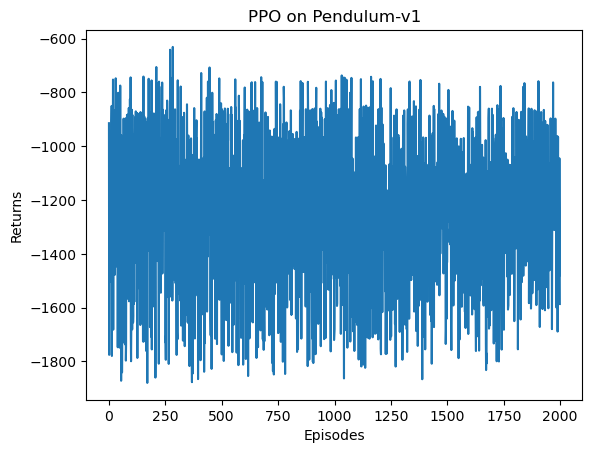

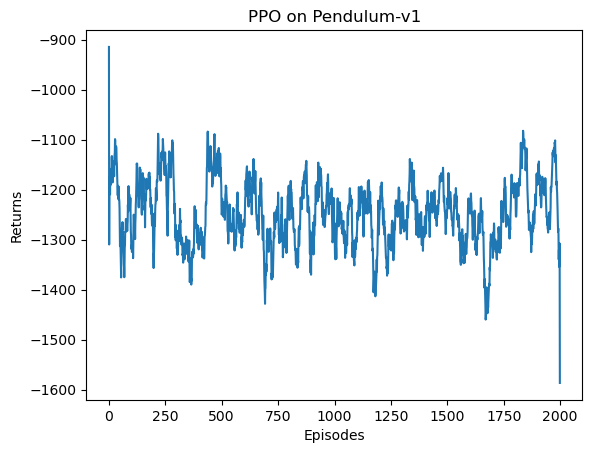

In [35]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('PPO on {}'.format(env_name))
plt.show()

mv_return = moving_average(return_list, 21)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('PPO on {}'.format(env_name))
plt.show()